<a href="https://colab.research.google.com/github/Rqkko/time-series-forecasting/blob/main/timeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
# Download Nikkei 225 Data
symbol = "^N225"
start_date = "2000-01-01"
end_date = "2025-05-31"
data = yf.download(symbol, start=start_date, end=end_date)
data.head()

/tmp/ipython-input-28-2844239282.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2000-01-04,19002.859375,19187.609375,18937.449219,18937.449219,0
2000-01-05,18542.550781,19003.509766,18221.820312,19003.509766,0
2000-01-06,18168.269531,18582.740234,18168.269531,18574.009766,0
2000-01-07,18193.410156,18285.730469,18068.099609,18194.050781,0
2000-01-11,18850.919922,18887.560547,18246.099609,18246.099609,0


In [29]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2025-05-26,37531.531250,37531.531250,37167.011719,37209.261719,89900000
2025-05-27,37724.109375,37769.050781,37411.679688,37523.371094,86200000
2025-05-28,37722.398438,38178.730469,37709.710938,38094.789062,122600000
2025-05-29,38432.980469,38454.070312,38035.320312,38046.968750,133200000
2025-05-30,37965.101562,38114.468750,37748.171875,37912.488281,204300000


In [30]:
# Keep only closing prices
df = data[["Close"]].copy()
df.rename(columns={"Close": "Price"}, inplace=True)
df.head()

Price,Price
Ticker,^N225
Date,
2000-01-04,19002.859375
2000-01-05,18542.550781
2000-01-06,18168.269531
2000-01-07,18193.410156
2000-01-11,18850.919922


In [31]:
# Calculate daily returns
df["Return"] = df["Price"].pct_change()

# Apply log transformation for variance stabilization
df["LogPrice"] = np.log(df["Price"])
df["LogReturn"] = df["LogPrice"].diff()

# Handle missing values
df.ffill(inplace=True)  # Forward fill
df.dropna(inplace=True)  # Drop any remaining NaNs
df.head()

Price,Price,Return,LogPrice,LogReturn
Ticker,^N225,,,
Date,,,,
2000-01-05,18542.550781,-0.024223,9.827823,-0.024521
2000-01-06,18168.269531,-0.020185,9.807432,-0.020391
2000-01-07,18193.410156,0.001384,9.808815,0.001383
2000-01-11,18850.919922,0.036140,9.844317,0.035502
2000-01-12,18677.419922,-0.009204,9.835071,-0.009246


<Figure size 1400x400 with 0 Axes>

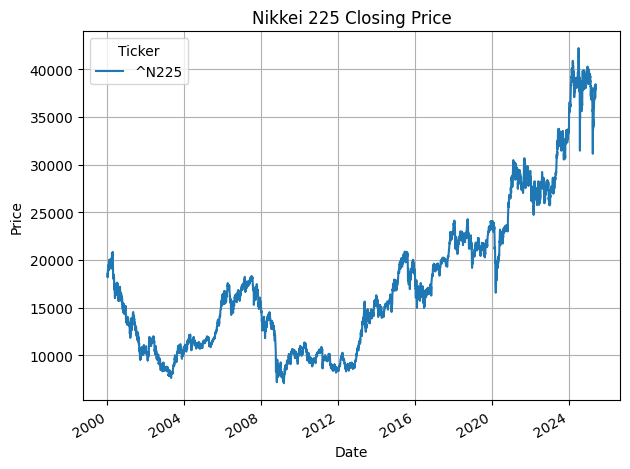

In [32]:
# Price over time
plt.figure(figsize=(14, 4))
df["Price"].plot(title="Nikkei 225 Closing Price", ylabel="Price", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

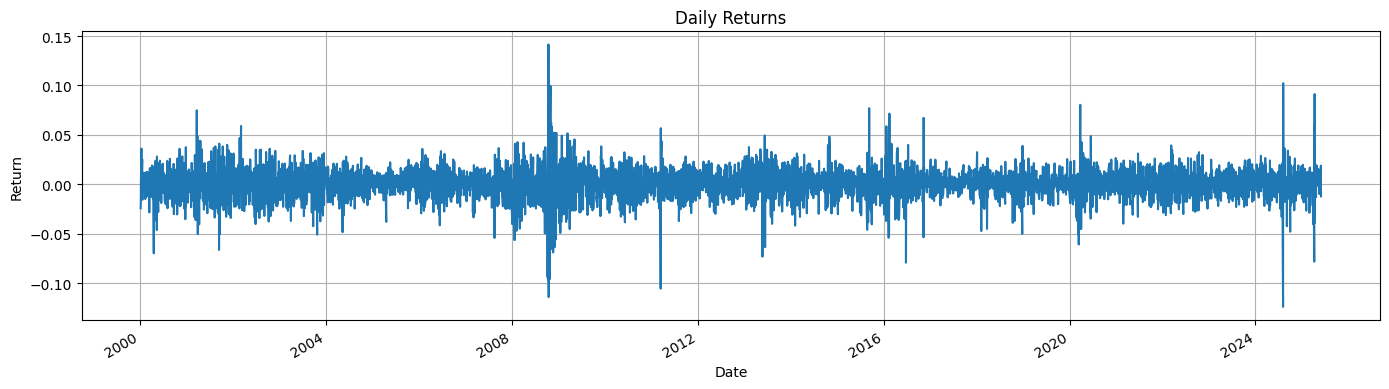

In [33]:
# Daily returns over time
plt.figure(figsize=(14, 4))
df["Return"].plot(title="Daily Returns", ylabel="Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

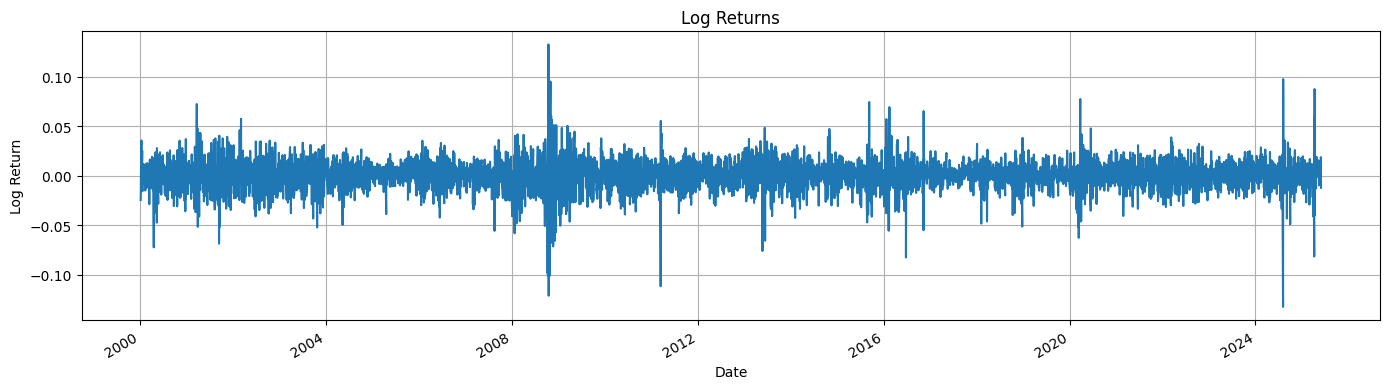

In [34]:
# Log returns over time
plt.figure(figsize=(14, 4))
df["LogReturn"].plot(title="Log Returns", ylabel="Log Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

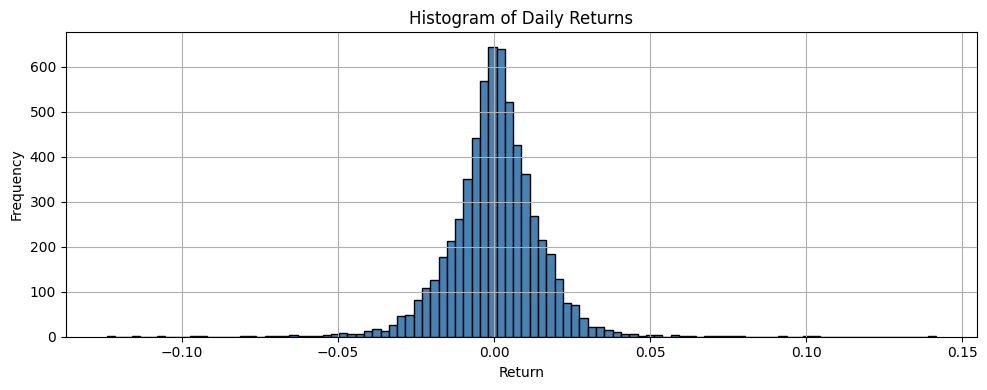

In [35]:
# Histogram of returns
plt.figure(figsize=(10, 4))
plt.hist(df["Return"], bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

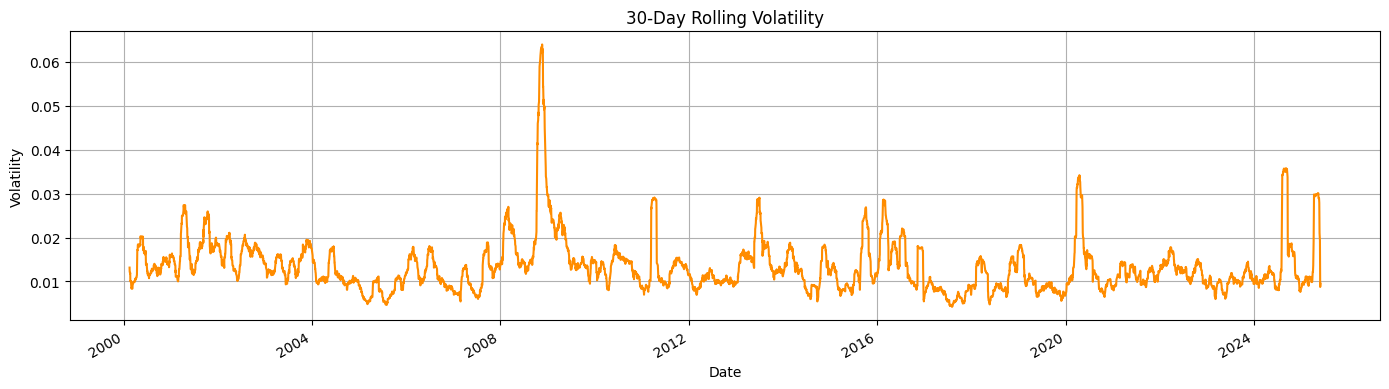

In [36]:
# Rolling volatility (30-day std of returns)
df["Volatility"] = df["Return"].rolling(window=30).std()

plt.figure(figsize=(14, 4))
df["Volatility"].plot(title="30-Day Rolling Volatility", ylabel="Volatility", xlabel="Date", color='darkorange')
plt.grid(True)
plt.tight_layout()
plt.show()

# Models

In [11]:
# Model Evaluation
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"Evaluation for {model_name}:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return {"model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mape}

## Benchmark Models

### Naive Forecast

In [12]:
#Naive model

# If your columns are still multi-indexed, flatten them again (just in case)
df.columns = [col[0] for col in df.columns]

# Recreate the NaiveForecast column
df["NaiveForecast"] = df["Price"].shift(1)

# Recreate the DataFrame used for evaluation
naive_df = df.dropna(subset=["NaiveForecast"])

In [13]:
# Zoom into recent data
naive_df_zoom = naive_df.loc["2023-01-01":"2025-05-31"]

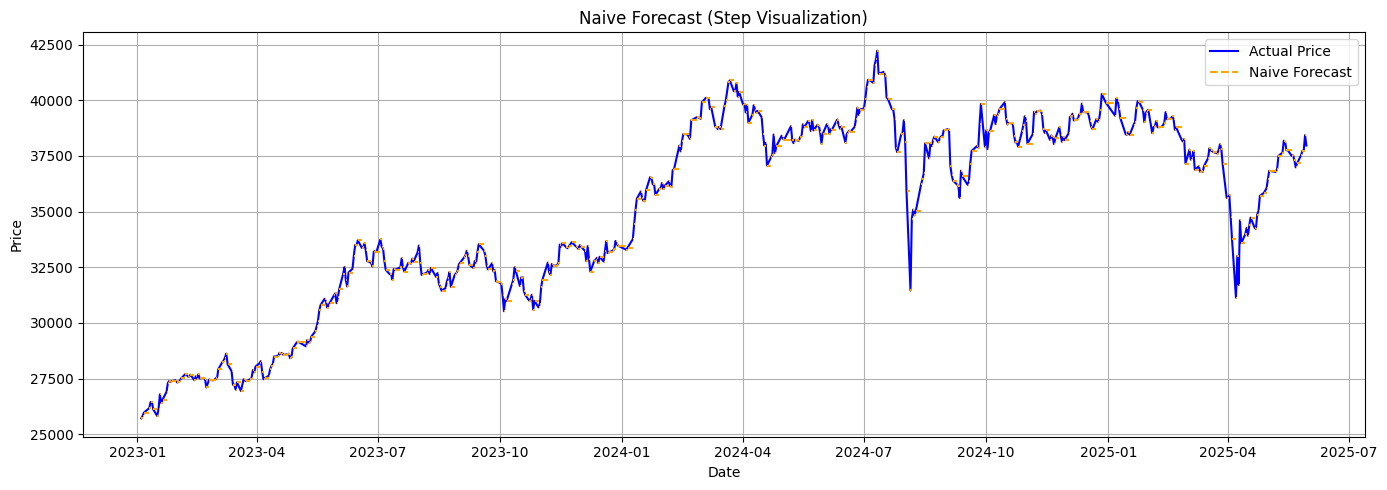

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")

# Draw horizontal lines for each naive prediction (step-style)
for i in range(1, len(naive_df_zoom)):
    x_vals = [naive_df_zoom.index[i-1], naive_df_zoom.index[i]]
    y_vals = [naive_df_zoom["NaiveForecast"].iloc[i]] * 2
    plt.plot(x_vals, y_vals, color="orange", linestyle="--")

plt.title("Naive Forecast (Step Visualization)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Actual Price", "Naive Forecast"])
plt.grid(True)
plt.tight_layout()
plt.show()

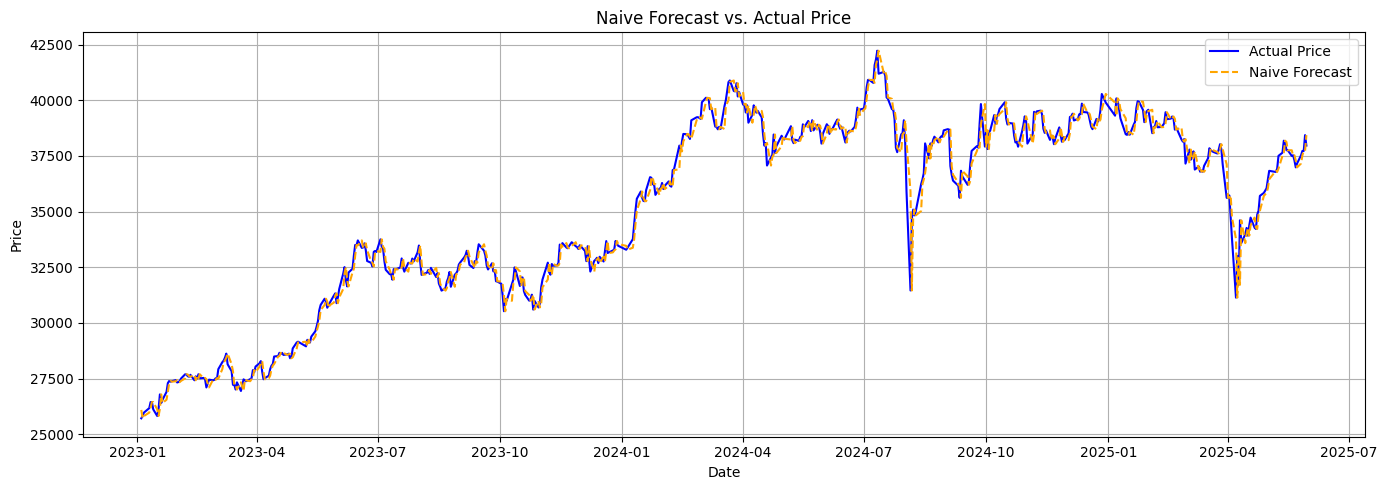

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")
plt.plot(naive_df_zoom.index, naive_df_zoom["NaiveForecast"], label="Naive Forecast", color="orange", linestyle="--")

plt.title("Naive Forecast vs. Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Evaluate
results_naive = evaluate_forecast(
    y_true=naive_df["Price"],
    y_pred=naive_df["NaiveForecast"],
    model_name="Naive"
)

Evaluation for Naive:
MAE:  173.18
RMSE: 262.44
MAPE: 1.04%


### SMA

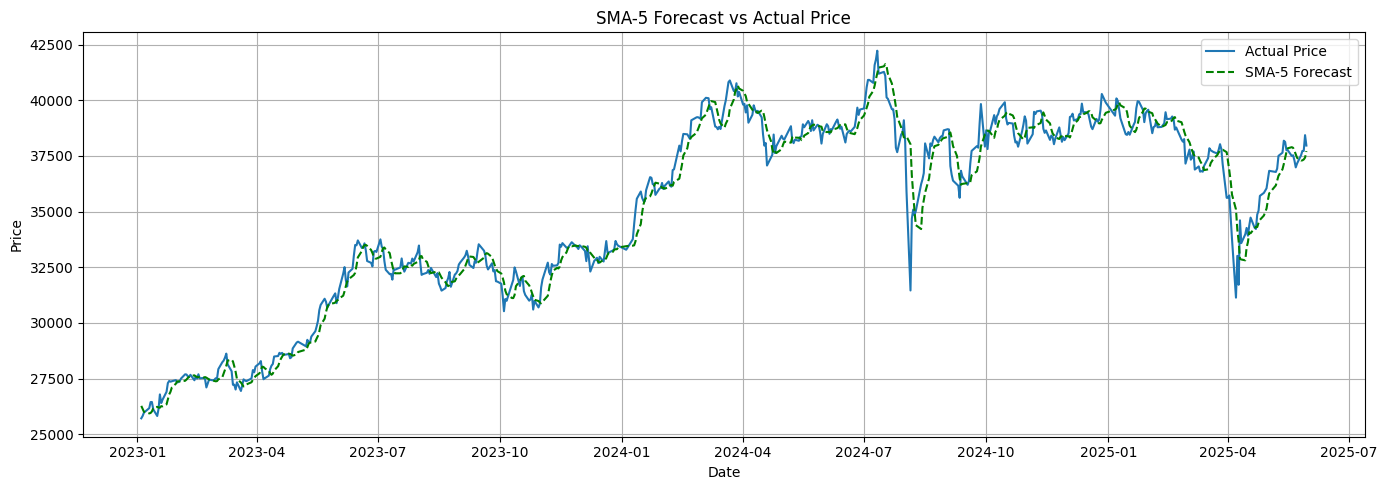

SMA-5 Model MAE: 259.0134
SMA-5 Model RMSE: 377.7869
SMA-3: MAE = 217.38
SMA-5: MAE = 259.01
SMA-10: MAE = 341.01
SMA-20: MAE = 457.67
SMA-30: MAE = 547.26


In [17]:
# Define SMA window size (e.g., 5 days)
window_size = 5

# SMA forecast: mean of last `window_size` prices
df["SMAForecast"] = df["Price"].shift(1).rolling(window=window_size).mean()

# Drop rows with NaN due to shift and rolling
sma_df = df.dropna(subset=["SMAForecast"])

# Plot actual vs SMA forecast (zoom into recent)
sma_df_zoom = sma_df.loc["2023-01-01":"2025-05-31"]

plt.figure(figsize=(14, 5))
plt.plot(sma_df_zoom.index, sma_df_zoom["Price"], label="Actual Price")
plt.plot(sma_df_zoom.index, sma_df_zoom["SMAForecast"], label=f"SMA-{window_size} Forecast", linestyle="--", color="green")
plt.title(f"SMA-{window_size} Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sma = mean_absolute_error(sma_df["Price"], sma_df["SMAForecast"])
rmse_sma = np.sqrt(mean_squared_error(sma_df["Price"], sma_df["SMAForecast"]))

print(f"SMA-{window_size} Model MAE: {mae_sma:.4f}")
print(f"SMA-{window_size} Model RMSE: {rmse_sma:.4f}")

for window_size in [3, 5, 10, 20, 30]:
    forecast = df["Price"].shift(1).rolling(window=window_size).mean()
    valid = df[~forecast.isna()]
    mae = mean_absolute_error(valid["Price"], forecast.dropna())
    print(f"SMA-{window_size}: MAE = {mae:.2f}")

In [18]:
# Evaluate
results_sma = evaluate_forecast(
    y_true=sma_df["Price"],
    y_pred=sma_df["SMAForecast"],
    model_name="SMA"
)

Evaluation for SMA:
MAE:  259.01
RMSE: 377.79
MAPE: 1.55%


## Classical Models

### Holt-Winters

In [19]:
!pip install statsmodels

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
# # Ensure index is datetime and data is at a regular frequency
# df = df.asfreq('B')  # Business days (adjust if needed)
# df["Price"] = df["Price"].ffill()

# # Pick recent data for faster model training
# train_data = df["Price"].loc["2018-01-01":"2024-12-31"]

# # Choose seasonal period (e.g., 252 for yearly if daily data, 5 for weekly)
# seasonal_period = 252

# # 🔹 ADDITIVE Holt-Winters model
# model_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)
# fit_add = model_add.fit()

# # 🔹 MULTIPLICATIVE Holt-Winters model
# model_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=seasonal_period)
# fit_mul = model_mul.fit()

# # Forecast next N days
# forecast_horizon = 90
# forecast_add = fit_add.forecast(forecast_horizon)
# forecast_mul = fit_mul.forecast(forecast_horizon)

# plt.figure(figsize=(16, 6))

# # Additive
# plt.plot(train_data.index, train_data, label='Train')
# plt.plot(forecast_add.index, forecast_add, label='Additive Forecast', linestyle='--', color='green')

# # Multiplicative
# plt.plot(forecast_mul.index, forecast_mul, label='Multiplicative Forecast', linestyle='--', color='orange')

# plt.title("Holt-Winters Forecast (Additive vs Multiplicative)")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Assuming actual test data exists
# test_data = df["Price"].loc["2025-01-01":"2025-05-31"]

# from sklearn.metrics import mean_absolute_error, mean_squared_error

# mae_add = mean_absolute_error(test_data[:len(forecast_add)], forecast_add)
# mae_mul = mean_absolute_error(test_data[:len(forecast_mul)], forecast_mul)

# print(f"Additive MAE: {mae_add:.2f}")
# print(f"Multiplicative MAE: {mae_mul:.2f}")

In [21]:
# Ensure index is datetime and data is at a regular frequency
df = df.asfreq('B')  # Business days (adjust if needed)
df["Price"] = df["Price"].ffill()

# Pick recent data for faster model training
train_data = df["Price"].loc["2003-01-01":"2022-12-31"]

# Choose seasonal period (e.g., 252 for yearly if daily data, 5 for weekly)
seasonal_period = 252

# 🔹 ADDITIVE Holt-Winters model
model_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)
fit_add = model_add.fit()

# 🔹 MULTIPLICATIVE Holt-Winters model
model_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=seasonal_period)
fit_mul = model_mul.fit()

# Forecast next N days
forecast_horizon = df.loc["2023-01-01":"2025-05-30"].shape[0]
forecast_add = fit_add.forecast(forecast_horizon)
forecast_mul = fit_mul.forecast(forecast_horizon)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


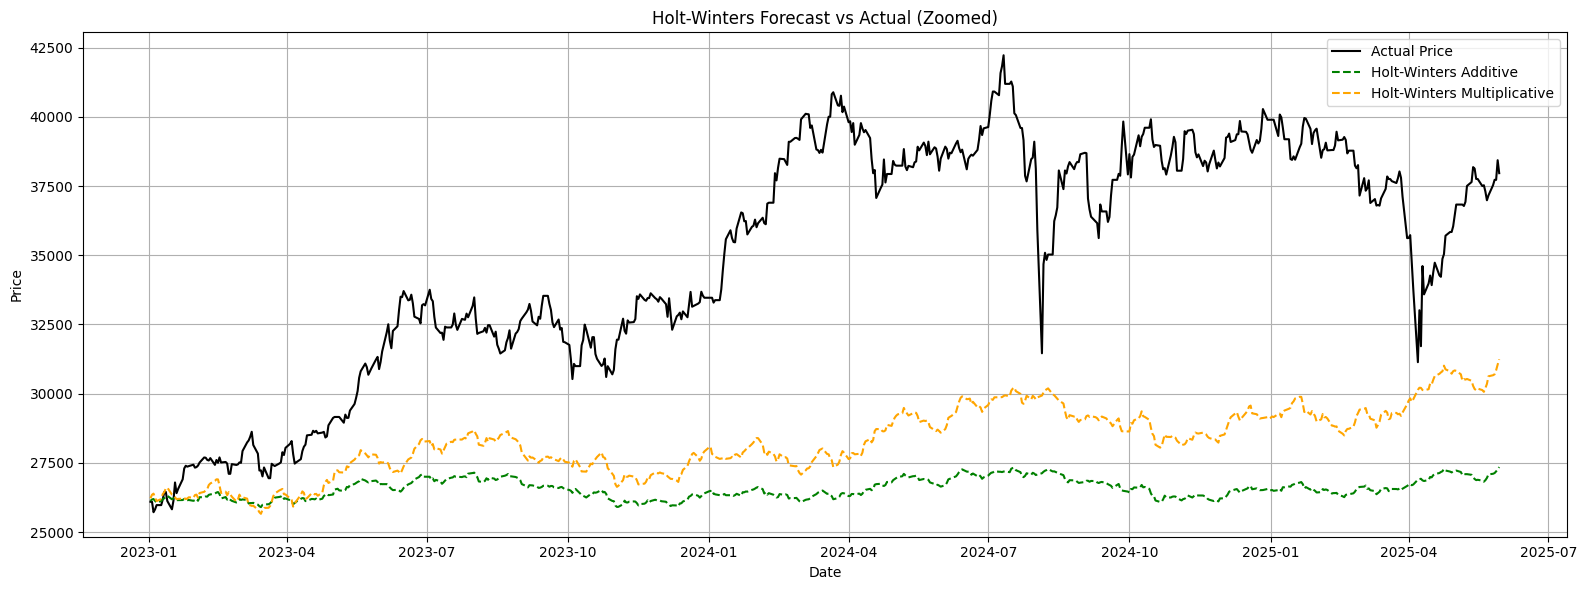

In [22]:
test_data_subset = df["Price"].loc[forecast_add.index]

# Define zoom range
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"

# Actual price in zoom range
actual_zoom = df["Price"].loc[zoom_start:zoom_end]

# Filter forecasts to the same range (align indices)
forecast_add_zoom = forecast_add.loc[zoom_start:zoom_end]
forecast_mul_zoom = forecast_mul.loc[zoom_start:zoom_end]

# Plot
plt.figure(figsize=(16, 6))
plt.plot(actual_zoom.index, actual_zoom, label="Actual Price", color="black")
plt.plot(forecast_add_zoom.index, forecast_add_zoom, label="Holt-Winters Additive", linestyle='--', color="green")
plt.plot(forecast_mul_zoom.index, forecast_mul_zoom, label="Holt-Winters Multiplicative", linestyle='--', color="orange")
plt.title("Holt-Winters Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# # Assuming actual test data exists
# test_data = df["Price"].loc["2023-01-01":"2025-05-30"]

# from sklearn.metrics import mean_absolute_error, mean_squared_error

# mae_add = mean_absolute_error(test_data_subset, forecast_add)
# mae_mul = mean_absolute_error(test_data_subset, forecast_mul)

# rmse_add = mean_squared_error(test_data_subset, forecast_add)
# rmse_mul = mean_squared_error(test_data_subset, forecast_mul)

# print(f"Additive MAE: {mae_add:.2f}, RMSE: {rmse_add:.2f}")
# print(f"Multiplicative MAE: {mae_mul:.2f}, RMSE: {rmse_mul:.2f}")

In [24]:
# Evaluate
results_hw_add = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_add,
    model_name="Holt-Winters Additive"
)

results_hw_mul = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_mul,
    model_name="Holt-Winters Multiplicative"
)

Evaluation for Holt-Winters Additive:
MAE:  8440.81
RMSE: 9376.16
MAPE: 22.97%
Evaluation for Holt-Winters Multiplicative:
MAE:  6748.71
RMSE: 7561.84
MAPE: 18.35%


### ARIMA

/tmp/ipython-input-25-1684029378.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nikkei = yf.download('^N225', start='2000-01-01', end='2025-05-31')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-25-1684029378.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nikkei.fillna(method='ffill', inplace=True)


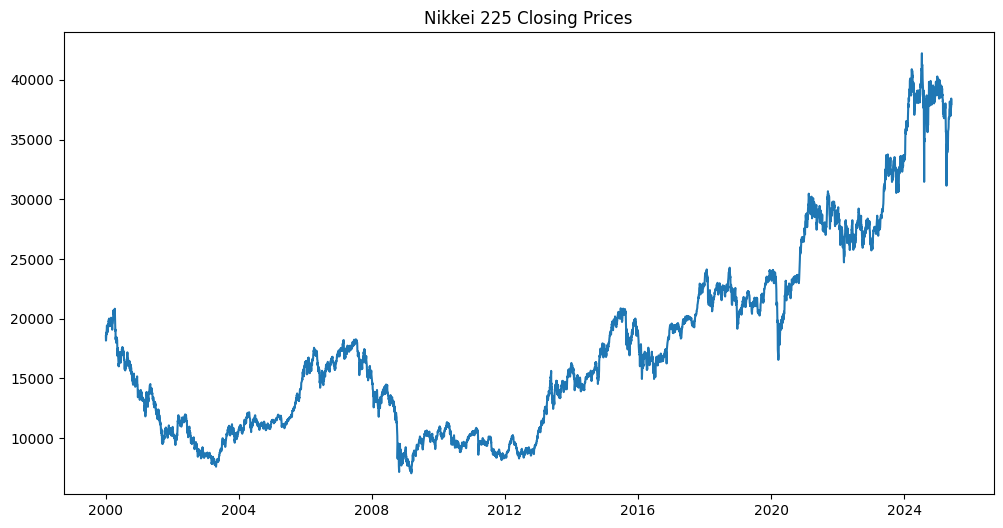

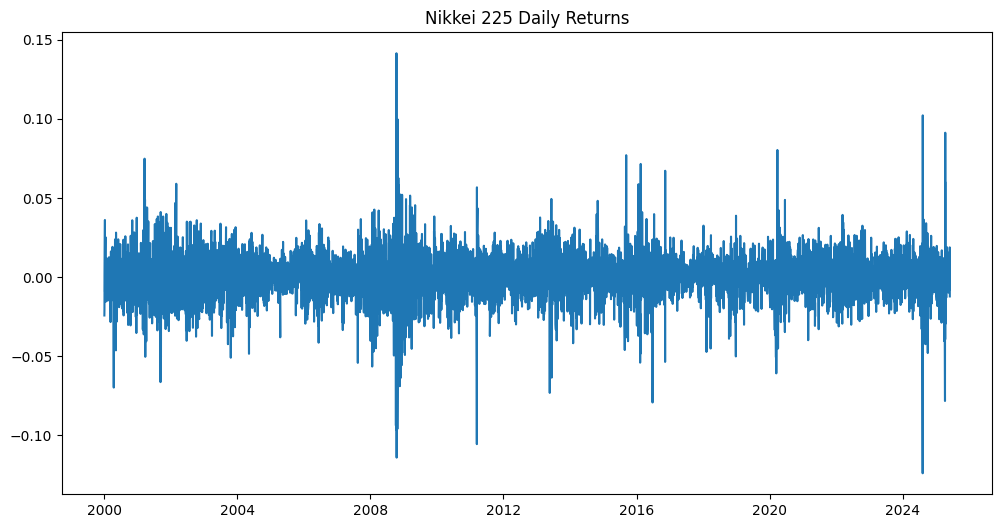

Naïve Forecast - RMSE: 262.3276796543964 MAE: 173.09331942685722
SMA Forecast - RMSE: 279.93949786634386 MAE: 191.23626433987573
EWMA Forecast - RMSE: 248.43590201580298 MAE: 170.14691985925052


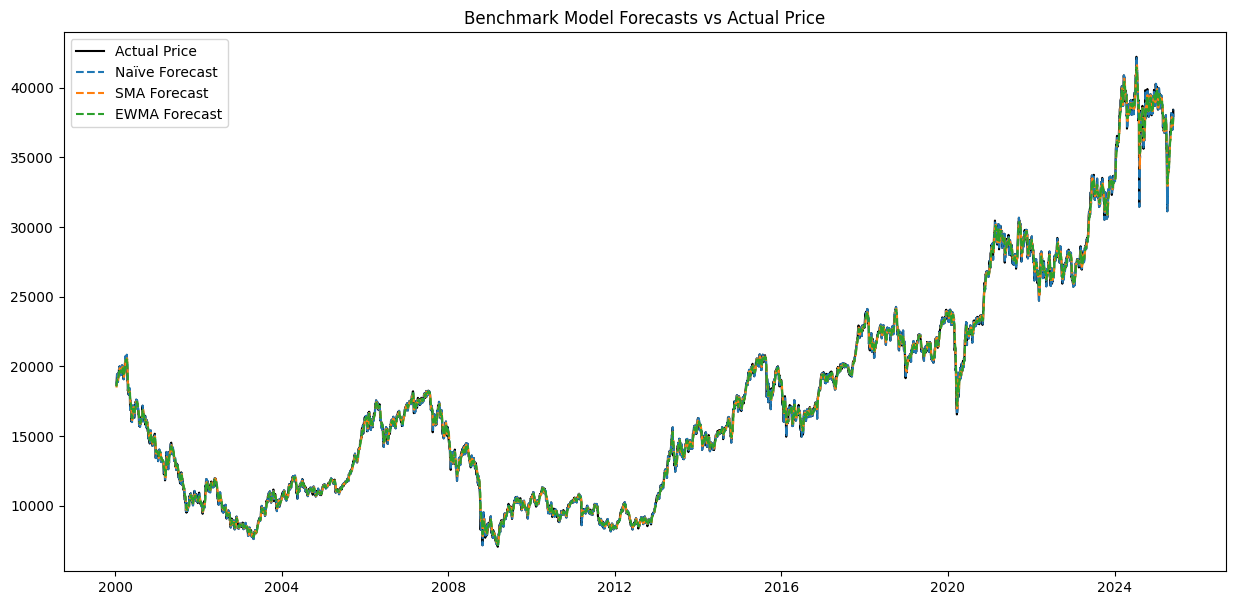

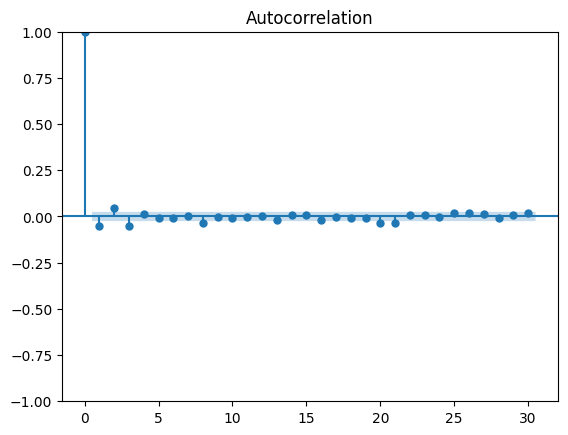

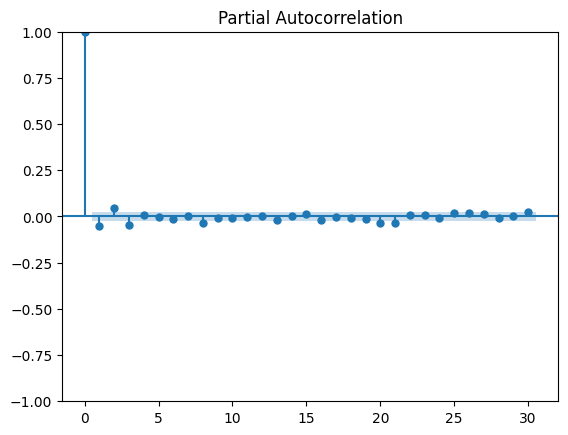

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

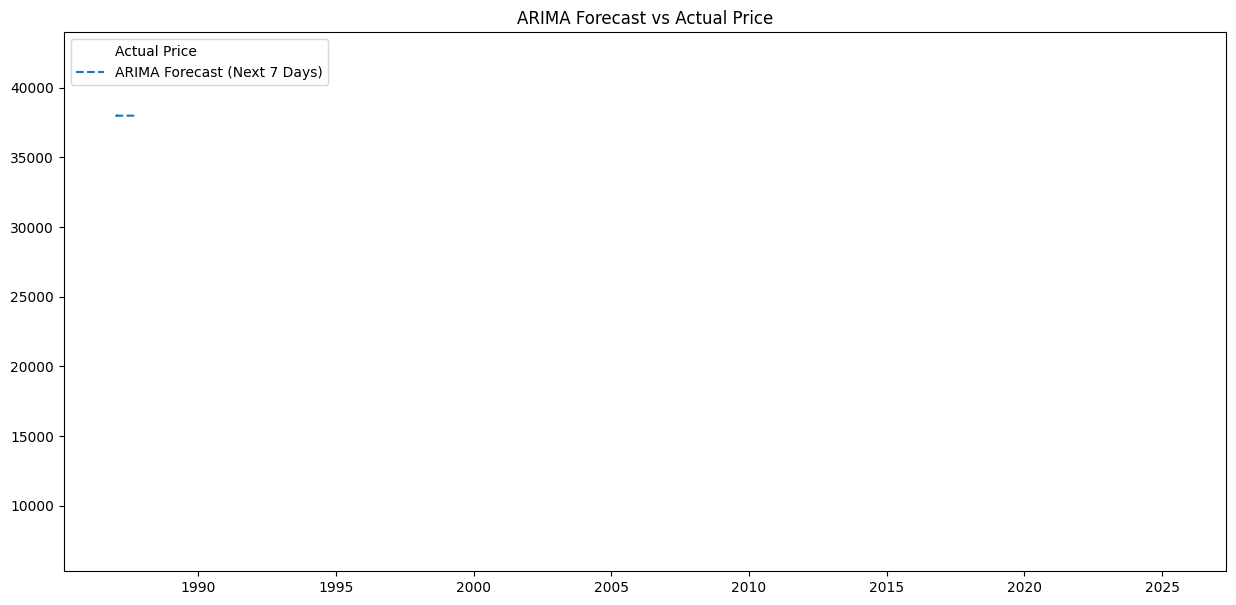

7-Day ARIMA Forecast:
6218    38017.879941
6219    37983.458265
6220    38005.907832
6221    37991.266387
6222    38000.815432
            ...     
6478    37997.046006
6479    37997.046006
6480    37997.046006
6481    37997.046006
6482    37997.046006
Name: predicted_mean, Length: 265, dtype: float64


In [25]:
# V1

# # # -*- coding: utf-8 -*-
# # """tsf_dataPreprocessing.ipynb

# # Automatically generated by Colab.

# # Original file is located at
# #     https://colab.research.google.com/drive/14iThCJk1_Qaw6aj0LS0tl4TDarHDEdTq
# # """

# # =============================
# # Nikkei 225 Benchmark Models
# # =============================

# Step 1: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 2: Download Data
nikkei = yf.download('^N225', start='2000-01-01', end='2025-05-31')
nikkei = nikkei[['Close']]
nikkei.rename(columns={'Close': 'Price'}, inplace=True)

# Step 3: Calculate Returns
nikkei['Return'] = nikkei['Price'].pct_change()
nikkei.dropna(inplace=True)

# Step 4: Handle Missing Values
nikkei.fillna(method='ffill', inplace=True)

# Step 5: Plot Raw Data
plt.figure(figsize=(12, 6))
plt.plot(nikkei['Price'])
plt.title('Nikkei 225 Closing Prices')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(nikkei['Return'])
plt.title('Nikkei 225 Daily Returns')
plt.show()

# Step 6: Benchmark Models
# 6.1 Naïve Forecast
nikkei['Naive_Price'] = nikkei['Price'].shift(1)

# 6.2 Simple Moving Average (SMA)
window_size = 5
nikkei['SMA_Price'] = nikkei['Price'].rolling(window=window_size).mean()

# 6.3 Exponentially Weighted Moving Average (EWMA)
alpha = 0.3
nikkei['EWMA_Price'] = nikkei['Price'].ewm(alpha=alpha, adjust=False).mean()

# Step 7: Drop NaN Values from Benchmark Models
nikkei.dropna(inplace=True)

# Step 8: Evaluation Function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Step 9: Calculate Errors for Benchmark Models
rmse_naive, mae_naive = evaluate(nikkei['Price'], nikkei['Naive_Price'])
rmse_sma, mae_sma = evaluate(nikkei['Price'], nikkei['SMA_Price'])
rmse_ewma, mae_ewma = evaluate(nikkei['Price'], nikkei['EWMA_Price'])

# Step 10: Print Benchmark Results
print('Naïve Forecast - RMSE:', rmse_naive, 'MAE:', mae_naive)
print('SMA Forecast - RMSE:', rmse_sma, 'MAE:', mae_sma)
print('EWMA Forecast - RMSE:', rmse_ewma, 'MAE:', mae_ewma)

# Step 11: Plot Benchmark Forecasts vs Actual
plt.figure(figsize=(15, 7))
plt.plot(nikkei['Price'], label='Actual Price', color='black')
plt.plot(nikkei['Naive_Price'], label='Naïve Forecast', linestyle='--')
plt.plot(nikkei['SMA_Price'], label='SMA Forecast', linestyle='--')
plt.plot(nikkei['EWMA_Price'], label='EWMA Forecast', linestyle='--')
plt.legend()
plt.title('Benchmark Model Forecasts vs Actual Price')
plt.show()

# Step 12: ARIMA Preprocessing - Differencing
nikkei['Diff'] = nikkei['Price'].diff()
nikkei.dropna(inplace=True)

# Step 13: Plot ACF and PACF for ARIMA Order Selection
plot_acf(nikkei['Diff'], lags=30)
plt.show()

plot_pacf(nikkei['Diff'], lags=30)
plt.show()

# Step 14: ARIMA Forecasting (Example with order (1,1,1))
model = ARIMA(nikkei['Price'], order=(1, 1, 1))
model_fit = model.fit()

# Step 15: Forecast Next 7 Days
forecast = model_fit.forecast(steps=265)

# Step 16: Plot ARIMA Forecast vs Actual
plt.figure(figsize=(15, 7))
plt.plot(nikkei['Price'], label='Actual Price', color='white')
plt.plot(forecast.index, forecast, label='ARIMA Forecast (Next 7 Days)', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast vs Actual Price')
plt.show()

# Step 17: Print Forecasted Prices
print('7-Day ARIMA Forecast:')
print(forecast)

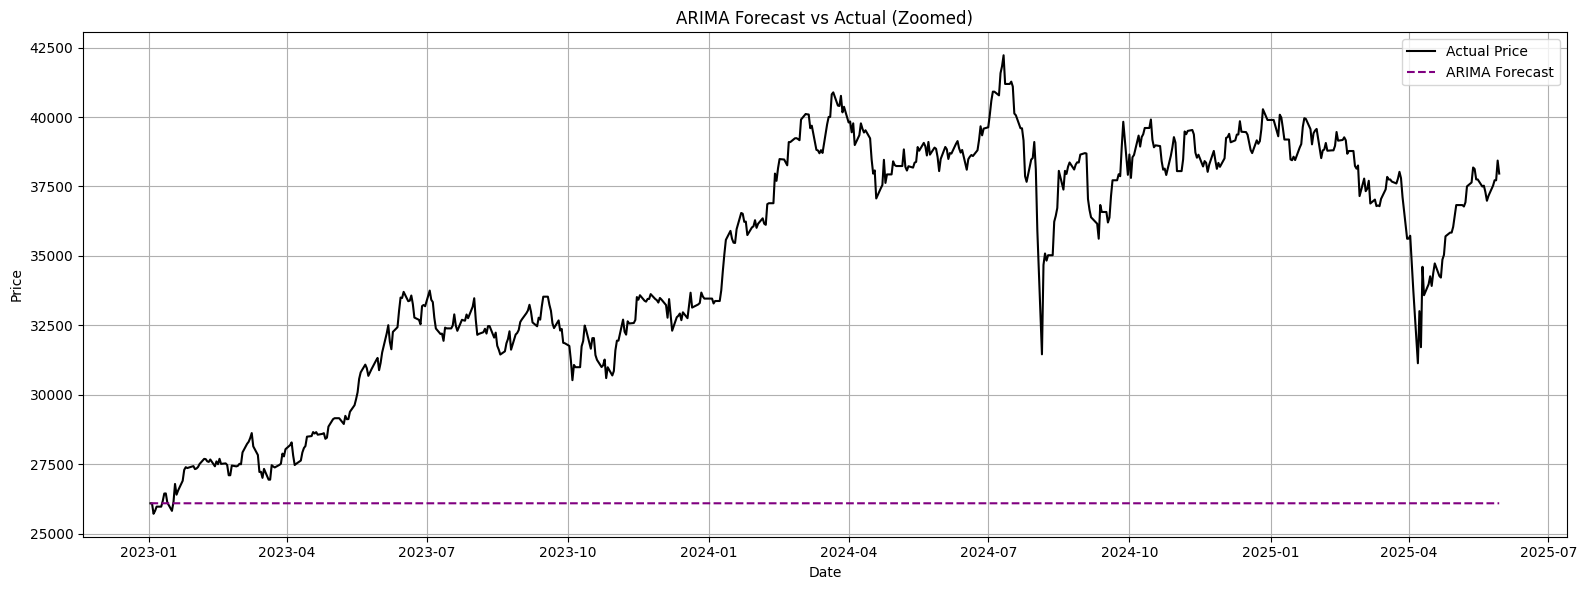

In [27]:
# V2 (by Rakko)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index and handle missing data
# df = df.asfreq("B")
# df["Price"] = df["Price"].ffill()

# --- 1. Split Data ---
arima_train_data = df["Price"].loc["2003-01-01":"2022-12-31"]
arima_test_data = df["Price"].loc["2023-01-01":"2025-05-30"]

# --- 2. Fit ARIMA Model ---
# You can change order=(p,d,q) if needed (currently (1,1,1) as a basic starting point)
arima_model = ARIMA(arima_train_data, order=(5, 1, 1))
arima_model_fit = arima_model.fit()

# --- 3. Forecast ---
forecast_horizon = len(arima_test_data)
forecast_arima = arima_model_fit.forecast(steps=forecast_horizon)
forecast_arima.index = arima_test_data.index  # align index for plotting and comparison

# --- 4. Evaluate ---
# mae_arima = mean_absolute_error(test_data, forecast_arima)
# rmse_arima = mean_squared_error(test_data, forecast_arima, squared=False)

# print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

# --- 5. Plot (Zoomed like other models) ---
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
actual_zoom = arima_test_data.loc[zoom_start:zoom_end]
forecast_arima_zoom = forecast_arima.loc[zoom_start:zoom_end]

plt.figure(figsize=(16, 6))
plt.plot(actual_zoom.index, actual_zoom, label="Actual Price", color="black")
plt.plot(forecast_arima_zoom.index, forecast_arima_zoom, label="ARIMA Forecast", linestyle="--", color="purple")
plt.title("ARIMA Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# V3



## Advanced Models

### Prophet (Meta)

In [32]:
# from prophet import Prophet

# # Prepare the DataFrame for Prophet
# prophet_df = df.reset_index()
# prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Price': 'y'})

# # Flatten the column index
# prophet_df.columns = prophet_df.columns.get_level_values(0)

# # Initialize and fit the Prophet model
# model = Prophet(
#     yearly_seasonality=True,
#     weekly_seasonality=True,
#     daily_seasonality=False  # Set to True if you have daily data and want to model daily seasonality
# )
# model.fit(prophet_df)

# # Create a DataFrame for future predictions (e.g., next 365 days)
# future = model.make_future_dataframe(periods=365)

# # Make predictions
# forecast = model.predict(future)

In [28]:
from prophet import Prophet

# Prepare the DataFrame for Prophet
prophet_df = df.reset_index()
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Price': 'y'})

# Train-test split
train_prophet = prophet_df[(prophet_df['ds'] >= '2003-01-01') & (prophet_df['ds'] <= '2022-12-31')]
test_prophet = prophet_df[(prophet_df['ds'] >= '2023-01-01') & (prophet_df['ds'] <= '2025-05-30')]
# Flatten the column index
train_prophet.columns = train_prophet.columns.get_level_values(0)

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train_prophet)

# Forecast length = test period length
forecast_horizon = test_prophet.shape[0]

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=forecast_horizon, freq='B')
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprw3kff4d/249ydtld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprw3kff4d/5px2qs_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92761', 'data', 'file=/tmp/tmprw3kff4d/249ydtld.json', 'init=/tmp/tmprw3kff4d/5px2qs_k.json', 'output', 'file=/tmp/tmprw3kff4d/prophet_modeldhhbe6ub/prophet_model-20250708073159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
# # Display the first few rows of the forecast
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# # Plot the forecast
# fig = model.plot(forecast)
# plt.title("Nikkei 225 Price Forecast with Prophet")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.show()

# # Plot components of the forecast
# fig2 = model.plot_components(forecast)
# plt.show()

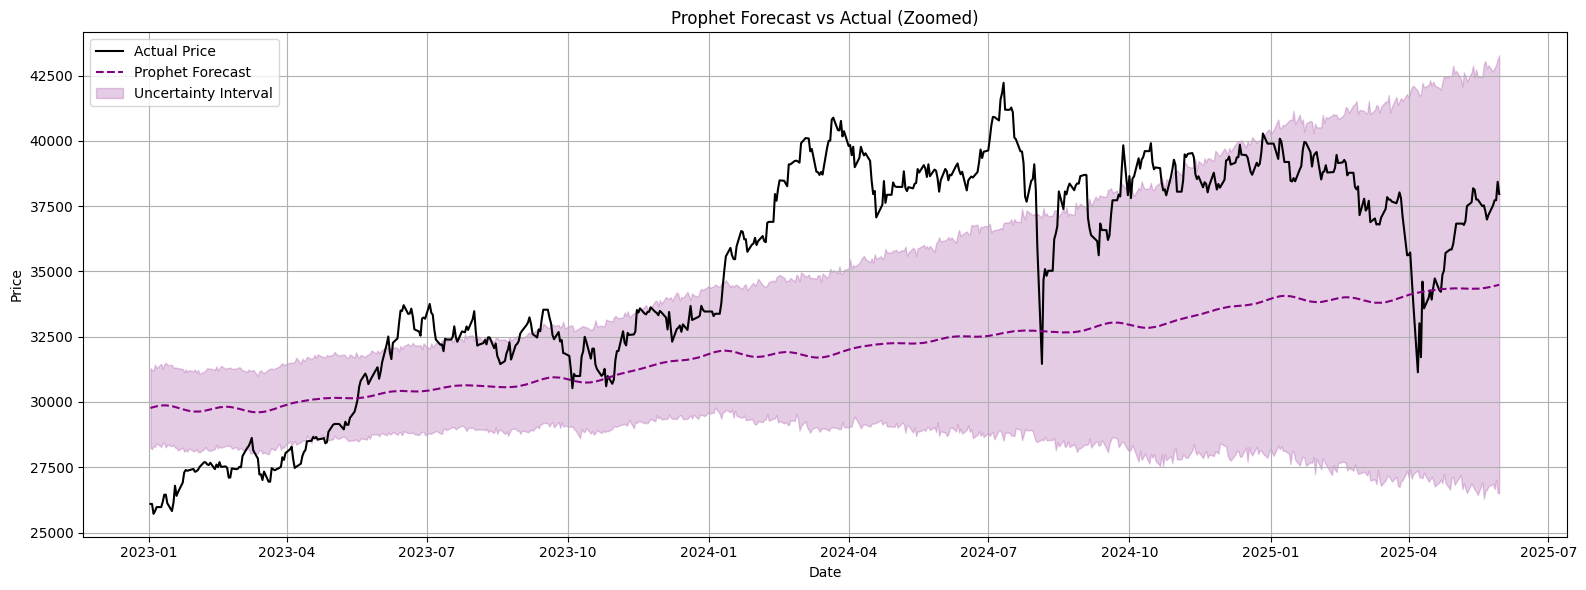

In [30]:
# Extract only the forecasted range (match test data)
forecast_subset = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2025-05-30')]

# Zoomed Plot: Forecast vs Actual
plt.figure(figsize=(16, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label="Actual Price", color="black")
plt.plot(forecast_subset['ds'], forecast_subset['yhat'], label="Prophet Forecast", linestyle='--', color="purple")
plt.fill_between(forecast_subset['ds'], forecast_subset['yhat_lower'], forecast_subset['yhat_upper'], color="purple", alpha=0.2, label="Uncertainty Interval")
plt.title("Prophet Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Evaluate

y_true = test_prophet['y'].values
y_pred = forecast_subset['yhat'].values

results_prophet = evaluate_forecast(
    y_true,
    y_pred,
    model_name="Prophet"
)

Evaluation for Prophet:
MAE:  3751.73
RMSE: 4376.88
MAPE: 10.27%


### N-BEATS

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# 2. Create sliding windows for supervised learning
class TimeSeriesDataset(Dataset):
    def __init__(self, series, backcast_length, forecast_length):
        self.X = []
        self.y = []
        for i in range(backcast_length, len(series) - forecast_length):
            self.X.append(series[i - backcast_length:i])
            self.y.append(series[i:i + forecast_length])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

log_returns = df["LogReturn"].values
backcast_length = 30
forecast_length = 7
dataset = TimeSeriesDataset(log_returns, backcast_length, forecast_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# N-BEATS Block
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
        super().__init__()
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
        ])
        self.relu = nn.ReLU()
        self.theta = nn.Linear(hidden_size, theta_size)
        self.backcast_proj = nn.Linear(theta_size, backcast_length)
        self.forecast_proj = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        theta = self.theta(x)
        backcast = self.backcast_proj(theta)
        forecast = self.forecast_proj(theta)
        return backcast, forecast

# N-BEATS Model
class NBeats(nn.Module):
    def __init__(self, input_size, backcast_length, forecast_length,
                 n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
                        backcast_length, forecast_length) for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

In [21]:
# Train the model
model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.6f}")

Epoch 1/10 - Loss: 0.000391
Epoch 2/10 - Loss: 0.000242
Epoch 3/10 - Loss: 0.000243
Epoch 4/10 - Loss: 0.000241
Epoch 5/10 - Loss: 0.000247
Epoch 6/10 - Loss: 0.000240
Epoch 7/10 - Loss: 0.000239
Epoch 8/10 - Loss: 0.000244
Epoch 9/10 - Loss: 0.000239
Epoch 10/10 - Loss: 0.000239


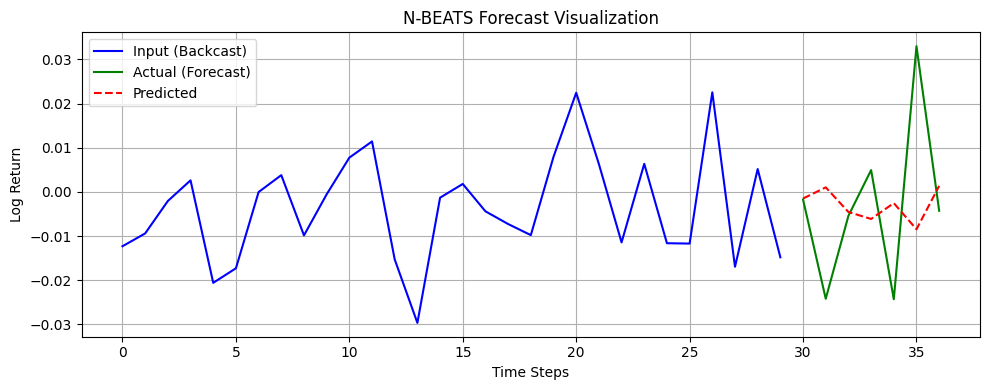

In [22]:
# Switch to eval mode
model.eval()

# Take one batch for visualization
with torch.no_grad():
    X_sample, y_true = next(iter(dataloader))
    y_pred = model(X_sample)

# Plot the first sample from the batch
idx = 0
plt.figure(figsize=(10, 4))
plt.plot(range(backcast_length), X_sample[idx].numpy(), label="Input (Backcast)", color='blue')
plt.plot(range(backcast_length, backcast_length + forecast_length),
         y_true[idx].numpy(), label="Actual (Forecast)", color='green')
plt.plot(range(backcast_length, backcast_length + forecast_length),
         y_pred[idx].numpy(), label="Predicted", color='red', linestyle='--')
plt.title("N-BEATS Forecast Visualization")
plt.xlabel("Time Steps")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Prepare Data
df = df.asfreq("B")
df["Price"] = df["Price"].ffill()
df["LogReturn"] = np.log(df["Price"] / df["Price"].shift(1))
df["LogReturn"] = df["LogReturn"].fillna(0)

train_log_returns = df.loc["2003-01-01":"2022-12-31", "LogReturn"].values
test_data = df["Price"].loc["2023-01-01":"2025-05-30"]
test_log_returns = df["LogReturn"].loc["2023-01-01":"2025-05-30"]
test_dates = test_log_returns.index
last_train_price = df.loc["2022-12-30", "Price"]  # last known price before test

# Define Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, backcast_length, forecast_length):
        self.X = []
        self.y = []
        for i in range(backcast_length, len(series) - forecast_length):
            self.X.append(series[i - backcast_length:i])
            self.y.append(series[i:i + forecast_length])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

backcast_length = 30
forecast_length = 7

train_dataset = TimeSeriesDataset(train_log_returns, backcast_length, forecast_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define N-BEATS Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
        super().__init__()
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
        ])
        self.relu = nn.ReLU()
        self.theta = nn.Linear(hidden_size, theta_size)
        self.backcast_proj = nn.Linear(theta_size, backcast_length)
        self.forecast_proj = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        theta = self.theta(x)
        backcast = self.backcast_proj(theta)
        forecast = self.forecast_proj(theta)
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, backcast_length, forecast_length,
                 n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
                        backcast_length, forecast_length) for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

In [47]:
# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}")

# Recursive Forecast on Test Set
model.eval()
input_window = torch.tensor(train_log_returns[-backcast_length:], dtype=torch.float32).to(device)
predicted_returns = []

predicted_returns = []
steps = len(test_log_returns)

with torch.no_grad():
    input_seq = input_window.clone()
    for _ in range(0, steps, forecast_length):
        forecast = model(input_seq.unsqueeze(0)).squeeze(0).cpu().numpy()
        take = min(forecast_length, steps - len(predicted_returns))
        predicted_returns.extend(forecast[:take])
        input_seq = torch.cat([
            input_seq[forecast_length:],
            torch.tensor(forecast[:take], dtype=torch.float32).to(device)
        ])

print("Len predicted_returns:", len(predicted_returns))
print("Len cumulative_returns:", len(cumulative_returns))
print("Len test_dates:", len(test_dates))
print("Shape test_dates:", test_dates.shape)
print("Last train price:", last_train_price.shape)

# Compute predicted prices
predicted_returns = np.array(predicted_returns)
cumulative_returns = np.cumprod(1 + predicted_returns)
last_train_price_value = float(last_train_price)  # ensure scalar
predicted_prices = last_train_price_value * cumulative_returns

# Make sure test_dates is an Index of length 630
predicted_prices = pd.Series(predicted_prices, index=test_dates)  # This must succeed
actual_prices = df.loc["2023-01-01":"2025-05-30", "Price"].values

Epoch 1/50 - Loss: 0.000148
Epoch 2/50 - Loss: 0.000000
Epoch 3/50 - Loss: 0.000000
Epoch 4/50 - Loss: 0.000000
Epoch 5/50 - Loss: 0.000000
Epoch 6/50 - Loss: 0.000000
Epoch 7/50 - Loss: 0.000001
Epoch 8/50 - Loss: 0.000001
Epoch 9/50 - Loss: 0.000001
Epoch 10/50 - Loss: 0.000001
Epoch 11/50 - Loss: 0.000001
Epoch 12/50 - Loss: 0.000002
Epoch 13/50 - Loss: 0.000001
Epoch 14/50 - Loss: 0.000001
Epoch 15/50 - Loss: 0.000001
Epoch 16/50 - Loss: 0.000001
Epoch 17/50 - Loss: 0.000001
Epoch 18/50 - Loss: 0.000001
Epoch 19/50 - Loss: 0.000001
Epoch 20/50 - Loss: 0.000001
Epoch 21/50 - Loss: 0.000001
Epoch 22/50 - Loss: 0.000001
Epoch 23/50 - Loss: 0.000001
Epoch 24/50 - Loss: 0.000001
Epoch 25/50 - Loss: 0.000002
Epoch 26/50 - Loss: 0.000001
Epoch 27/50 - Loss: 0.000002
Epoch 28/50 - Loss: 0.000001
Epoch 29/50 - Loss: 0.000001
Epoch 30/50 - Loss: 0.000001
Epoch 31/50 - Loss: 0.000001
Epoch 32/50 - Loss: 0.000001
Epoch 33/50 - Loss: 0.000001
Epoch 34/50 - Loss: 0.000001
Epoch 35/50 - Loss: 0.0

/tmp/ipython-input-47-403820640.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_train_price_value = float(last_train_price)  # ensure scalar


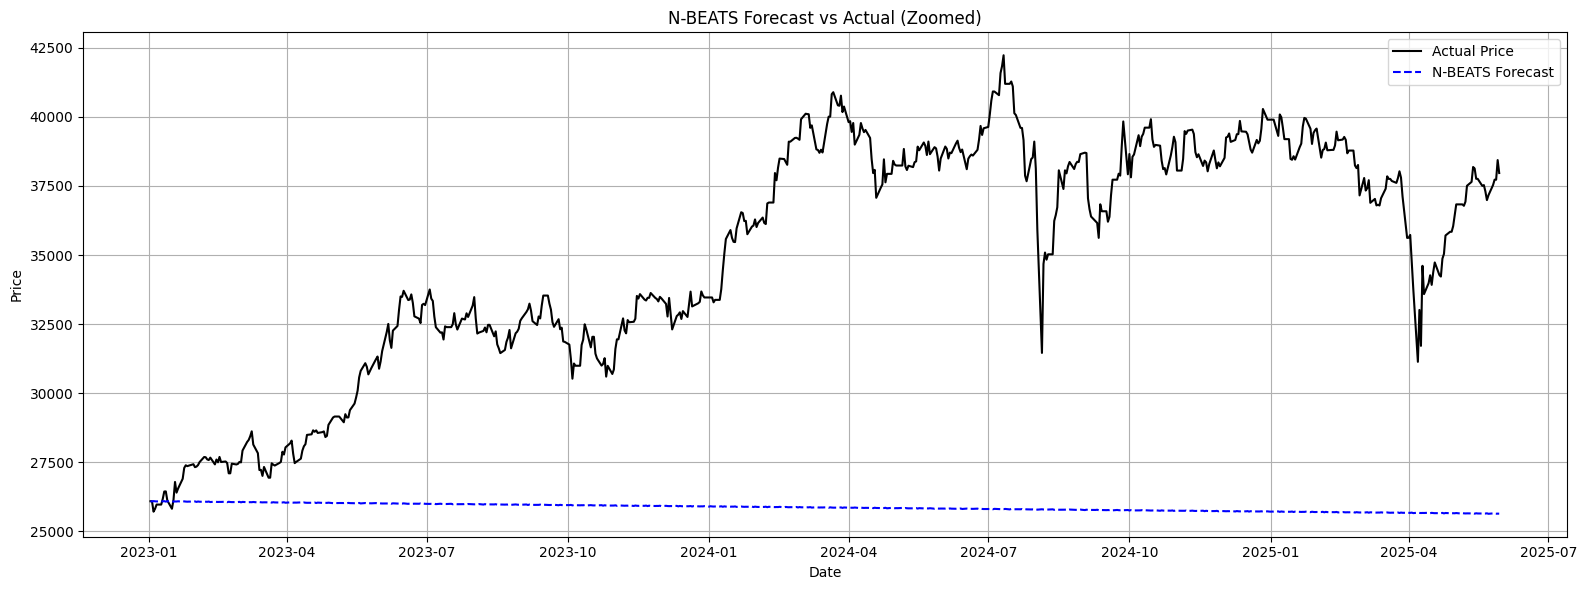

In [48]:
# Plot Zoomed Forecast (2024–2025)
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
zoom_idx = (test_dates >= zoom_start) & (test_dates <= zoom_end)

plt.figure(figsize=(16, 6))
plt.plot(test_dates[zoom_idx], actual_prices[zoom_idx], label="Actual Price", color="black")
plt.plot(test_dates[zoom_idx], predicted_prices[zoom_idx], label="N-BEATS Forecast", linestyle='--', color="blue")
plt.title("N-BEATS Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### New One Using Log Price

In [37]:
df.head(5)

Price,Price,Return,LogPrice,LogReturn,Volatility
Ticker,^N225,,,,
Date,,,,,
2000-01-05,18542.550781,-0.024223,9.827823,-0.024521,NaN
2000-01-06,18168.269531,-0.020185,9.807432,-0.020391,NaN
2000-01-07,18193.410156,0.001384,9.808815,0.001383,NaN
2000-01-11,18850.919922,0.036140,9.844317,0.035502,NaN
2000-01-12,18677.419922,-0.009204,9.835071,-0.009246,NaN


In [38]:
print(df[["Price"]].head(5))

Price              Price
Ticker             ^N225
Date                    
2000-01-05  18542.550781
2000-01-06  18168.269531
2000-01-07  18193.410156
2000-01-11  18850.919922
2000-01-12  18677.419922


In [39]:
print(df["Price"].isna().sum())

Ticker
^N225    0
dtype: int64


In [40]:
print((df["Price"] <= 0).sum())

Ticker
^N225    0
dtype: int64


In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# --- Load & preprocess data ---
# Ensure the index is datetime
df.index = pd.to_datetime(df.index)

# Drop rows where Price is NaN or non-positive BEFORE taking log
df = df[df["Price"].notna() & (df["Price"] > 0)].copy()

# Now safely take the log
df["LogPrice"] = np.log(df["Price"])
df.dropna(inplace=True)
print(df.head())

# Normalize log-prices
log_prices = df["LogPrice"].loc["2018-01-01":"2025-05-30"]
log_prices = log_prices.dropna()
mean = log_prices.mean()
std = log_prices.std()
log_prices_norm = (log_prices - log_prices.mean()) / log_prices.std()

# --- Dataset class ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, backcast_length, forecast_length):
        self.X = []
        self.y = []
        for i in range(backcast_length, len(series) - forecast_length):
            self.X.append(series[i - backcast_length:i])
            self.y.append(series[i:i + forecast_length])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Hyperparameters ---
backcast_length = 30
forecast_length = 7
dataset = TimeSeriesDataset(log_prices_norm, backcast_length, forecast_length)
print("Length of log_prices_norm:", len(log_prices_norm))
print("Required minimum:", backcast_length + forecast_length + 1)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- N-BEATS Blocks ---
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
        super().__init__()
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
        ])
        self.relu = nn.ReLU()
        self.theta = nn.Linear(hidden_size, theta_size)
        self.backcast_proj = nn.Linear(theta_size, backcast_length)
        self.forecast_proj = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        theta = self.theta(x)
        backcast = self.backcast_proj(theta)
        forecast = self.forecast_proj(theta)
        return backcast, forecast

# --- N-BEATS Model ---
class NBeats(nn.Module):
    def __init__(self, input_size, backcast_length, forecast_length,
                 n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
                        backcast_length, forecast_length) for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# --- Train the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.6f}")

# --- Eval & Visualization ---
model.eval()
with torch.no_grad():
    X_sample, y_true = next(iter(dataloader))
    X_sample, y_true = X_sample.to(device), y_true.to(device)
    y_pred = model(X_sample)

# Convert back from normalized log-price → price
def to_price(log_price_norm):
    log_price = log_price_norm * std + mean
    return np.exp(log_price)

# --- Plot example ---
idx = 0
plt.figure(figsize=(10, 4))
plt.plot(range(backcast_length),
         to_price(X_sample[idx].cpu().numpy()), label="Input (Backcast)", color='blue')
plt.plot(range(backcast_length, backcast_length + forecast_length),
         to_price(y_true[idx].cpu().numpy()), label="Actual (Forecast)", color='green')
plt.plot(range(backcast_length, backcast_length + forecast_length),
         to_price(y_pred[idx].cpu().numpy()), label="Predicted", color='red', linestyle='--')
plt.title("N-BEATS Log-Price Forecast → Price")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Empty DataFrame
Columns: [(Price, ^N225), (Return, ), (LogPrice, ), (LogReturn, ), (Volatility, )]
Index: []
Length of log_prices_norm: 0
Required minimum: 38


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}")

# Recursive Forecast on Test Set
model.eval()
input_window = torch.tensor(train_log_returns[-backcast_length:], dtype=torch.float32).to(device)
predicted_returns = []

predicted_returns = []
steps = len(test_log_returns)

with torch.no_grad():
    input_seq = input_window.clone()
    for _ in range(0, steps, forecast_length):
        forecast = model(input_seq.unsqueeze(0)).squeeze(0).cpu().numpy()
        take = min(forecast_length, steps - len(predicted_returns))
        predicted_returns.extend(forecast[:take])
        input_seq = torch.cat([
            input_seq[forecast_length:],
            torch.tensor(forecast[:take], dtype=torch.float32).to(device)
        ])

print("Len predicted_returns:", len(predicted_returns))
print("Len cumulative_returns:", len(cumulative_returns))
print("Len test_dates:", len(test_dates))
print("Shape test_dates:", test_dates.shape)
print("Last train price:", last_train_price.shape)

# Compute predicted prices
predicted_returns = np.array(predicted_returns)
cumulative_returns = np.cumprod(1 + predicted_returns)
last_train_price_value = float(last_train_price)  # ensure scalar
predicted_prices = last_train_price_value * cumulative_returns

# Make sure test_dates is an Index of length 630
predicted_prices = pd.Series(predicted_prices, index=test_dates)  # This must succeed
actual_prices = df.loc["2023-01-01":"2025-05-30", "Price"].values

In [ ]:
# Plot Zoomed Forecast (2024–2025)
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
zoom_idx = (test_dates >= zoom_start) & (test_dates <= zoom_end)

plt.figure(figsize=(16, 6))
plt.plot(test_dates[zoom_idx], actual_prices[zoom_idx], label="Actual Price", color="black")
plt.plot(test_dates[zoom_idx], predicted_prices[zoom_idx], label="N-BEATS Forecast", linestyle='--', color="blue")
plt.title("N-BEATS Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# Evaluation
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = mean_squared_error(actual_prices, predicted_prices)
print(f"N-BEATS MAE: {mae:.2f}, RMSE: {rmse:.2f}")

N-BEATS MAE: 8813.72, RMSE: 94827803.50


# Model Comparison & Evaluation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. Define naive forecast ---
def naive_forecast(series):
    return series.shift(1)

# --- 2. Create forecast ---
df["NaiveForecast"] = naive_forecast(df["Price"])

# --- 3. Define test period (2023 only) ---
test_mask = (df.index >= "2023-01-01") & (df.index <= "2023-12-31")
df_test = df.loc[test_mask].copy()

# Drop initial NaN caused by shift
df_test = df_test.dropna(subset=["NaiveForecast"])

# --- 4. Evaluate ---
true_values = df_test["Price"]
pred_values = df_test["NaiveForecast"]

rmse = np.sqrt(mean_squared_error(true_values, pred_values))
mae = mean_absolute_error(true_values, pred_values)

print(f"Naïve Forecast Evaluation on 2023:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

KeyError: ['NaiveForecast']